In [2]:
import sys, os
sys.path.insert(1, '/nfs/cms/martialc/DTUpgrade/src')

%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
from pathlib import Path
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit
import pyarrow as pa
import pyarrow.parquet as pq


from typing import TYPE_CHECKING

if TYPE_CHECKING:
    import dtupy_analysis.dqm as dqm
# %aimport dtupy_analysis.dqm
# dqm = dtupy_analysis.dqm

from dtupy_analysis.dqm import units as u, MuFile
from dtupy_analysis.dqm.reco import MuSTIO, MuSGO
from dtupy_analysis.utils.memory import Memory
from dtupy_analysis.utils.paths import load_yaml

In [4]:
patt_dict = load_yaml('/nfs/cms/martialc/DTUpgrade/cfg/dqm/reco/pattern.yaml')

In [5]:
!ls -hltr /nfs/cms/martialc/DTUpgrade/data/cosmic_240904_long.*
!ls -hltr /afs/cern.ch/user/r/redondo/work/public/sxa5/cosmic_test_0409_2.txt

-rw-r--r-- 1 martialc xv 137M Sep 24 16:13 /nfs/cms/martialc/DTUpgrade/data/cosmic_240904_long.parquet
-rw-r--r-- 1 martialc xv  22M Oct 30 04:21 /nfs/cms/martialc/DTUpgrade/data/cosmic_240904_long.seg
-rw-r--r-- 1 martialc xv  85M Nov  4 16:03 /nfs/cms/martialc/DTUpgrade/data/cosmic_240904_long.fits
-rw-r--r-- 1 49660 zh 3.4G Sep  4 12:33 /afs/cern.ch/user/r/redondo/work/public/sxa5/cosmic_test_0409_2.txt


In [6]:
src_df= pd.read_parquet('/nfs/cms/martialc/DTUpgrade/data/cosmic_240904_long_noThetaBounds.fits')
src_df

,seg_idx,st,sl,bx0,t4,t3,t2,t1,pattID,latsID,theta,x0,v,t0,chi2
0,24573,1,2,6680804512,93.75000,282.81250,20.31250,353.90625,RLR,RLRL,0.150337,297.378809,0.0545,-23.031644,0.004079
1,24578,1,2,6656479616,0.00000,141.40625,90.62500,64.06250,RLR,RLRL,-0.174259,218.935254,0.0545,-97.641019,0.130982
2,24582,1,2,6710858944,64.06250,270.31250,15.62500,198.43750,LRR,LRRL,-0.354713,462.319336,0.0545,-55.551175,2.950680
3,24585,1,2,6660468416,216.40625,100.00000,8.59375,301.56250,RLR,RLRL,0.405302,260.094336,0.0545,-87.191800,0.029006
4,24586,1,2,6670611616,189.84375,110.15625,9.37500,312.50000,RLR,RLRL,0.381555,469.455664,0.0545,-85.043363,0.355328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958324,1428287,1,1,2245588384,10.93750,203.90625,63.28125,124.21875,LRL,LRLR,0.137506,622.959473,0.0545,-75.570707,0.555200
958325,1428290,1,1,2321873856,7.81250,354.68750,148.43750,235.15625,RLR,RLRL,-0.266193,88.592285,0.0545,26.382418,0.330400
958326,1428291,1,1,2354151232,5.46875,228.90625,241.40625,10.15625,RLR,LLRR,-0.584966,472.734180,0.0545,-36.492976,0.045322
958327,1428293,1,1,2279493312,380.46875,14.06250,251.56250,197.65625,RRL,RRLR,-0.289201,655.879283,0.0545,-8.743753,4.507812


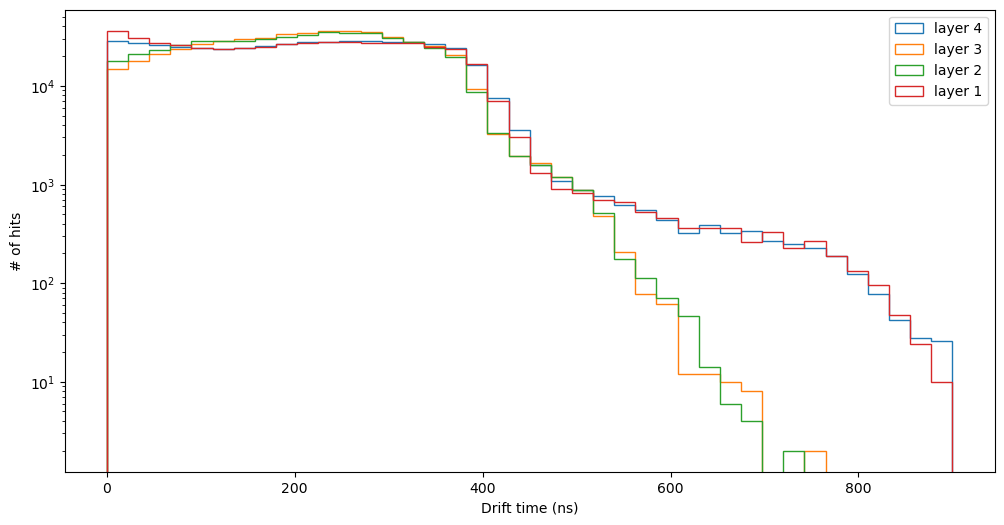

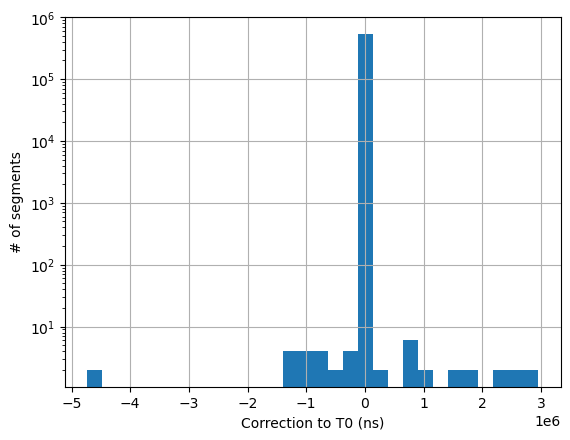

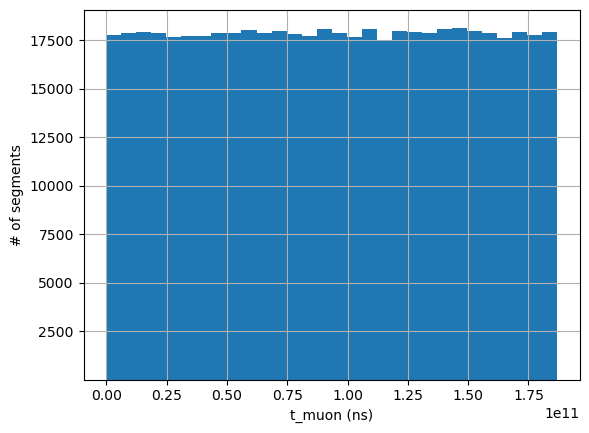

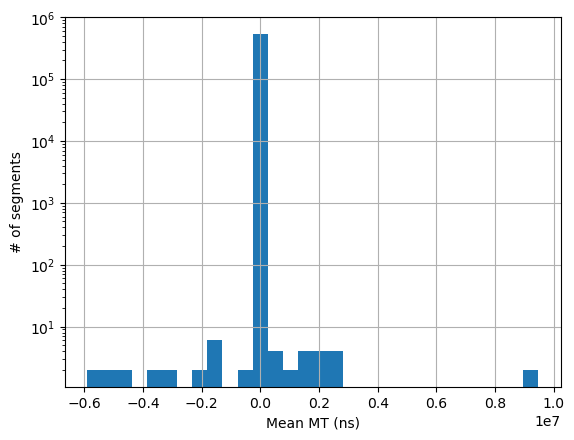

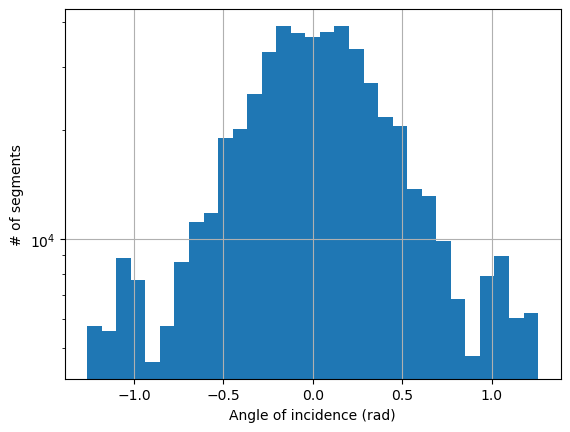

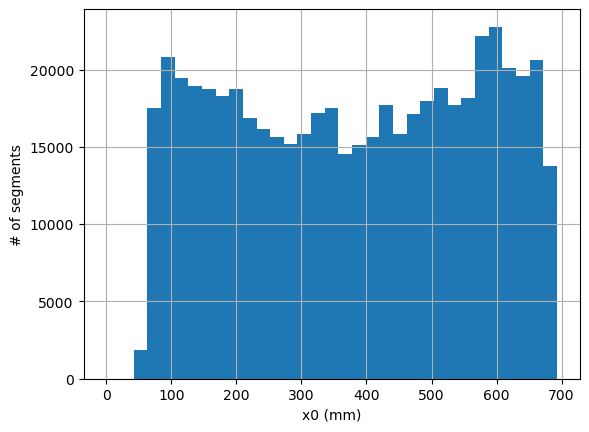

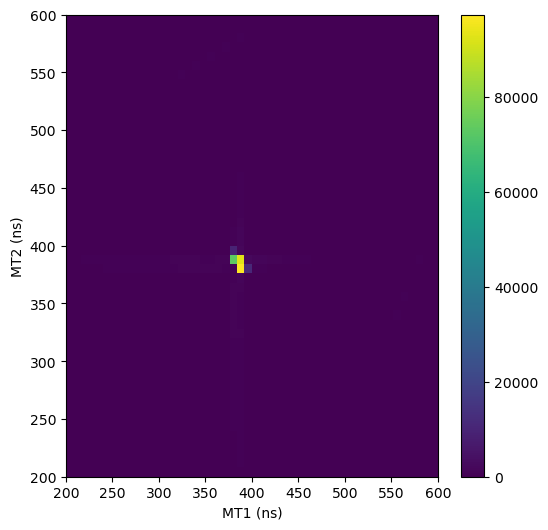

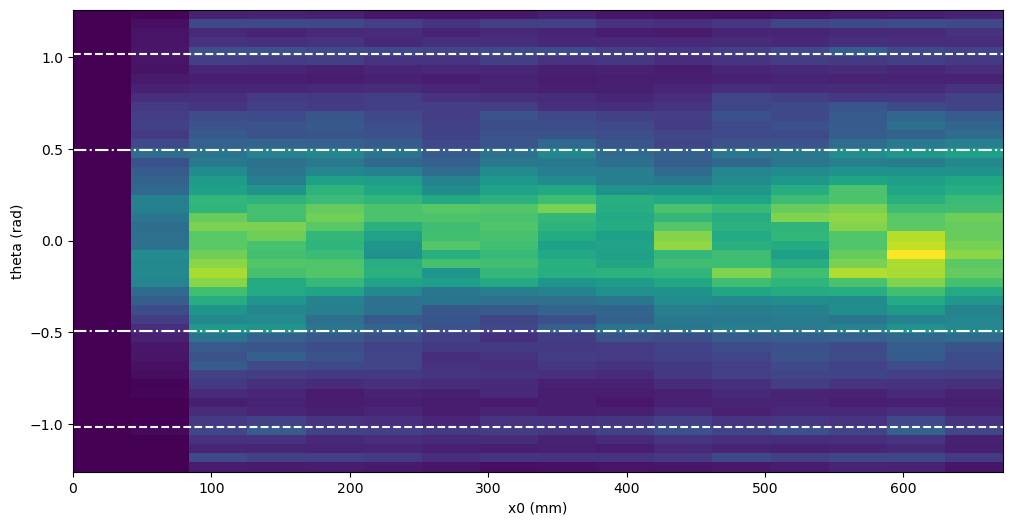

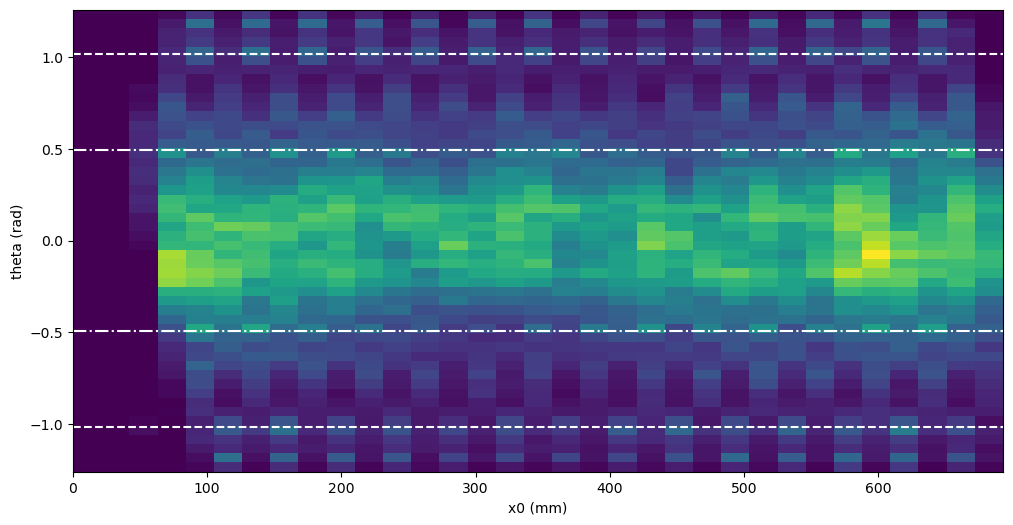

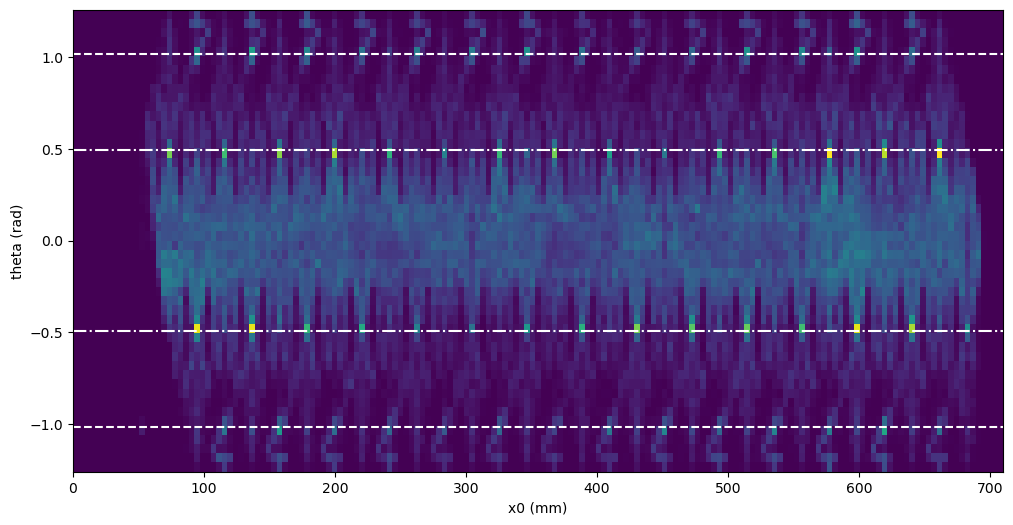

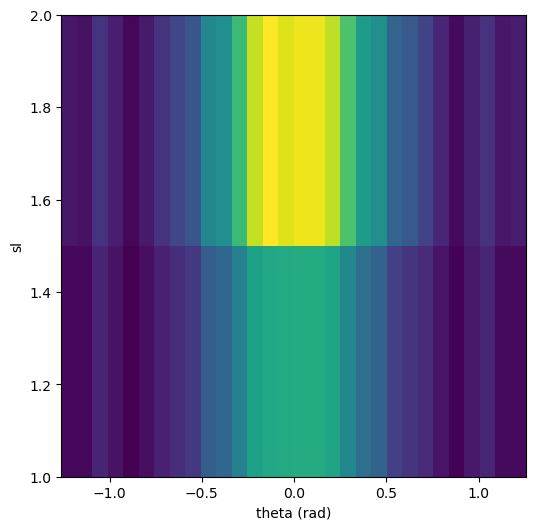

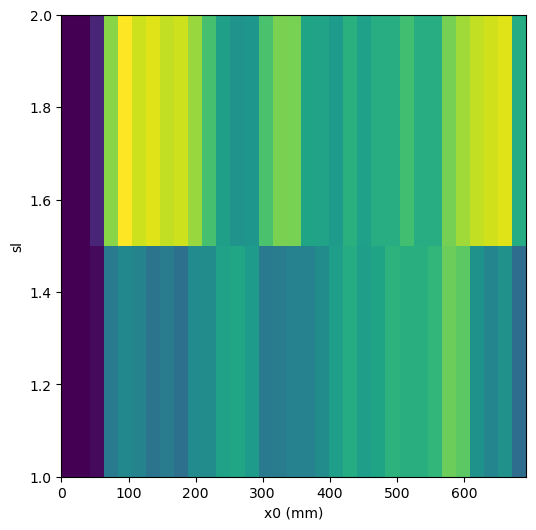

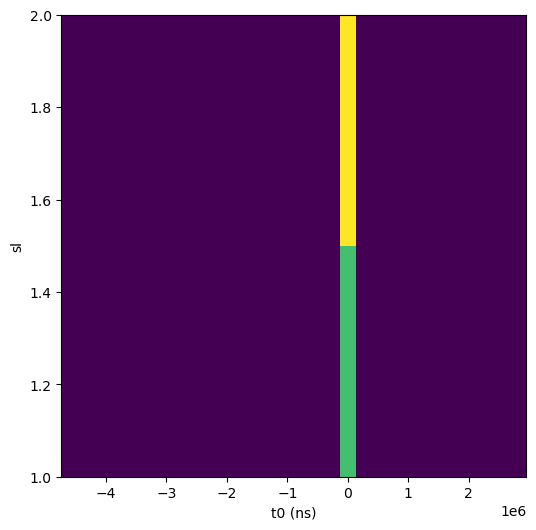

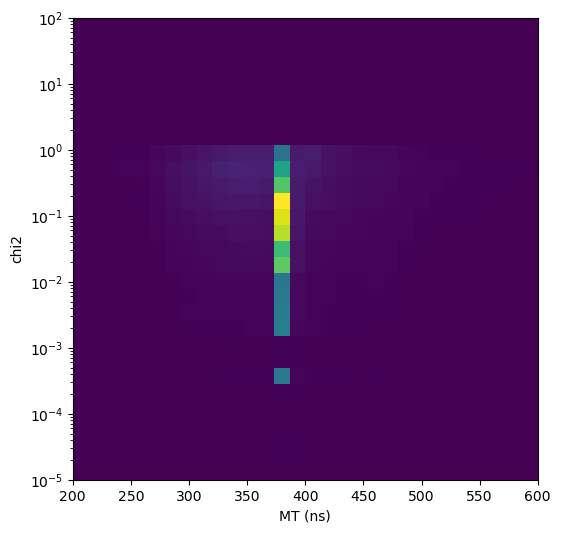

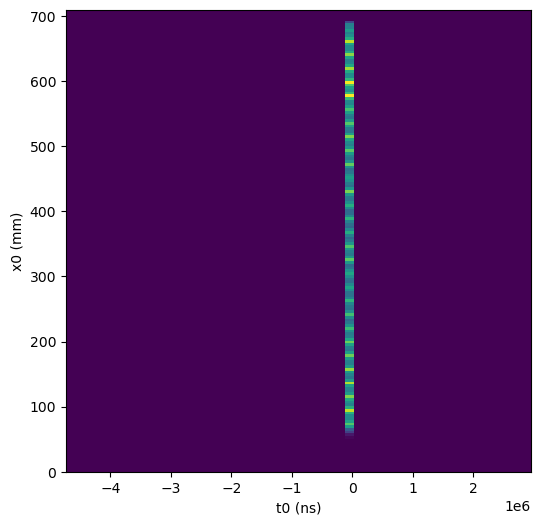

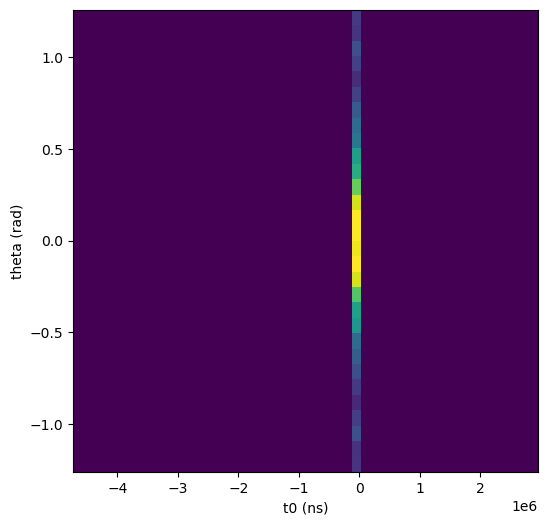

In [7]:
import re
fig, ax = plt.subplots(1,1, figsize=(12,6))
hists = []
df = src_df.copy()
df = df[df.chi2 < 1]

chi2_bins = np.logspace(-5, 2, 30)
for t_i in filter(lambda x: re.match(r'\At[1-9]\d*', x), df.columns):
    df[t_i] = df[t_i] - df['t0']
    hists.append(df[t_i])
    ax.hist(df[t_i],
            histtype='step', bins = 40, range = (0, 900), label = 'layer {}'.format(t_i[1:]), log=True)
ax.set_ylabel('# of hits')
ax.set_xlabel('Drift time (ns)')
plt.legend()
plt.show()


df['MT1'] = 0.5 * (df.t1 + df.t3) + df.t2
df['MT2'] = 0.5 * (df.t2 + df.t4) + df.t3
df['MT']  = 0.5 * (df.MT1 + df.MT2)

df['NT1'] = 0.5 * (df.t1 + df.t2)
df['NT2'] = 0.5 * (df.t3 + df.t4)
df['NT']  = 0.5 * (df.NT2 - df.NT1)


df.t0.dropna().hist(bins=30, log=True)
plt.gca().set_ylabel('# of segments')
plt.gca().set_xlabel('Correction to T0 (ns)')
plt.show()

(df.bx0*25 + df.t0).dropna().hist(bins = 30, log=False)
plt.gca().set_ylabel('# of segments')
plt.gca().set_xlabel('t_muon (ns)')
plt.ylim(1,None)
plt.show()


df.MT.dropna().hist(bins=30, log=True)
plt.gca().set_ylabel('# of segments')
plt.gca().set_xlabel('Mean MT (ns)')
plt.show()

df.theta.hist(bins=31, log=True)
plt.gca().set_ylabel('# of segments')
plt.gca().set_xlabel('Angle of incidence (rad)')
plt.show()

df.x0.hist(bins=np.arange(0,17*u.CELL_WIDTH, u.CELL_WIDTH/2), log=False)
plt.gca().set_ylabel('# of segments')
plt.gca().set_xlabel('x0 (mm)')
plt.show()


fig, ax = plt.subplots(1,1, figsize=(6,6))
h2=ax.hist2d(df.MT1, df.MT2, range =  2*[[200, 600]], bins = (50,50))
plt.colorbar(h2[3])
plt.xlim(200, 600)
plt.ylim(*plt.gca().get_xlim())

plt.xlabel('MT1 (ns)')
plt.ylabel('MT2 (ns)')

plt.show()



fig, ax = plt.subplots(1,1, figsize=(12,6))
_=ax.hist2d(df.x0, df.theta, bins = (np.arange(0,u.CELL_WIDTH*17,u.CELL_WIDTH),50))
for s in [-1,1]:
    ax.axhline(np.arctan(s*(0.5*u.CELL_WIDTH)/(3*u.CELL_HEIGHT)), color='white', linestyle='-.')
    # ax.axhline(np.arctan(s*(2.5*u.CELL_WIDTH)/(4*u.CELL_HEIGHT)), color='white', linestyle='--')
    ax.axhline(np.arctan(s*(2*u.CELL_WIDTH)/(4*u.CELL_HEIGHT)), color='white', linestyle='--')


ax.set_xlabel('x0 (mm)')
ax.set_ylabel('theta (rad)')
plt.show()

fig, ax = plt.subplots(1,1, figsize=(12,6))
_=ax.hist2d(df.x0, df.theta, bins = (np.arange(0,u.CELL_WIDTH*17,u.CELL_WIDTH/2),50))
for s in [-1,1]:
    ax.axhline(np.arctan(s*(0.5*u.CELL_WIDTH)/(3*u.CELL_HEIGHT)), color='white', linestyle='-.')
    # ax.axhline(np.arctan(s*(2.5*u.CELL_WIDTH)/(4*u.CELL_HEIGHT)), color='white', linestyle='--')
    ax.axhline(np.arctan(s*(2*u.CELL_WIDTH)/(4*u.CELL_HEIGHT)), color='white', linestyle='--')


ax.set_xlabel('x0 (mm)')
ax.set_ylabel('theta (rad)')
plt.show()

fig, ax = plt.subplots(1,1, figsize=(12,6))
_=ax.hist2d(df.x0, df.theta, bins = (np.arange(0,u.CELL_WIDTH*17,u.CELL_WIDTH/10),50))
for s in [-1,1]:
    ax.axhline(np.arctan(s*(0.5*u.CELL_WIDTH)/(3*u.CELL_HEIGHT)), color='white', linestyle='-.')
    # ax.axhline(np.arctan(s*(2.5*u.CELL_WIDTH)/(4*u.CELL_HEIGHT)), color='white', linestyle='--')
    ax.axhline(np.arctan(s*(2*u.CELL_WIDTH)/(4*u.CELL_HEIGHT)), color='white', linestyle='--')


ax.set_xlabel('x0 (mm)')
ax.set_ylabel('theta (rad)')
plt.show()


fig, ax = plt.subplots(1,1, figsize=(6,6))
_=ax.hist2d(df.theta, df.sl, bins = (30, 2))
# plt.yscale('log')
plt.ylabel('sl')
plt.xlabel('theta (rad)')
plt.show()

fig, ax = plt.subplots(1,1, figsize=(6,6))
_=ax.hist2d(df.x0, df.sl, bins = (np.arange(0,u.CELL_WIDTH*17,u.CELL_WIDTH/2), 2))
# plt.yscale('log')
plt.ylabel('sl')
plt.xlabel('x0 (mm)')
plt.show()

fig, ax = plt.subplots(1,1, figsize=(6,6))
_=ax.hist2d(df.t0, df.sl, bins = (30, 2))
# plt.yscale('log')
plt.ylabel('sl')
plt.xlabel('t0 (ns)')
plt.show()

fig, ax = plt.subplots(1,1, figsize=(6,6))
_=ax.hist2d(df.MT[~np.isnan(df.MT)], df.chi2[~np.isnan(df.MT)], bins = (30, chi2_bins), range = ((200, 600), (1e-5, 1)))
plt.yscale('log')
plt.ylabel('chi2')
plt.xlabel('MT (ns)')
plt.show()

fig, ax = plt.subplots(1,1, figsize=(6,6))
_=ax.hist2d(df.t0, df.x0, bins = (50, np.arange(0,u.CELL_WIDTH*17,u.CELL_WIDTH/10)))
# plt.yscale('log')
plt.ylabel('x0 (mm)')
plt.xlabel('t0 (ns)')
plt.show()

fig, ax = plt.subplots(1,1, figsize=(6,6))
_=ax.hist2d(df.t0, df.theta, bins = (50, 30))
# plt.yscale('log')
plt.ylabel('theta (rad)')
plt.xlabel('t0 (ns)')
plt.show()


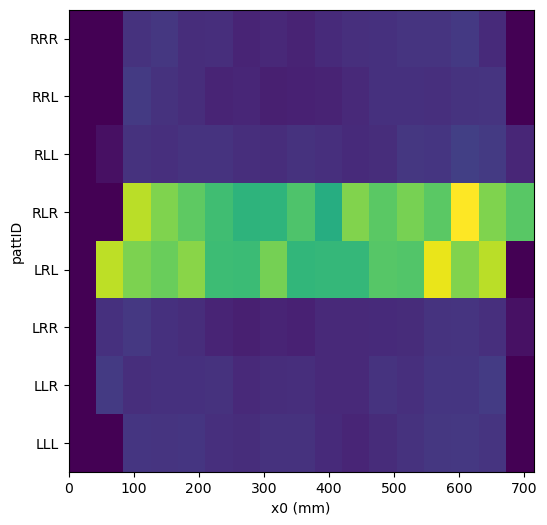

In [8]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
bins  = [-4,-3,-2,-1,0,1,2,3,4]
_=ax.hist2d(
    df.x0,
    df.pattID.apply(lambda x: np.sign(patt_dict[x]['int'])*(np.abs(patt_dict[x]['int']) - 0.5)),
    bins = (17, bins),
    range = [(0, 17*u.CELL_WIDTH), (-4, 4)]
)
# plt.yscale('log')
plt.ylabel('pattID')
yticks = np.arange(8)-3.5
yticklabels = []

for y in yticks.ravel():
    y = int(np.sign(y)*(np.abs(y) +0.5))
    for pattID, _dict in patt_dict.items():
        if _dict['int'] == y:
            yticklabels.append(pattID)
            break
        elif y == 0:
            yticklabels.append('')
            break
ax.set_yticks(yticks, yticklabels)
# ax.set_ylim(-4,5)
plt.xlabel('x0 (mm)')
plt.show()

In [9]:
def plot_split_pattID(df, var, bins = None, xrange = None, label = None, add_plot = None):
    import matplotlib.gridspec as gridspec


    # Crear una figura con un GridSpec de 2 columnas
    fig = plt.figure(figsize=(16, 4))
    gs = gridspec.GridSpec(len(patt_dict), 2, width_ratios=[1, 2])

    # Crear los subplots a la izquierda
    axes = [fig.add_subplot(gs[i, 0]) for i in range(len(patt_dict))]

    # Crear el subplot único a la derecha
    ax_right = fig.add_subplot(gs[:, 1])

    pattIDs = []
    data = []
    w = []
    N_list = []
    for pattID in patt_dict.keys():
        if isinstance(var, str):
            data_patt = df[df.pattID == pattID][var]
        else:
            data_patt = var(df[df.pattID == pattID])
        N = len(data_patt)
        
        if N == 0:
            continue
        else:
            data.append(data_patt)
            w.append(np.ones(N) / N)
            pattIDs.append(pattID)
            N_list.append(N)

    ordered_idx = [zipped[0][1] for zipped in zip(sorted(zip(N_list, range(len(N_list))), reverse=True))]
    ordered_data = [data[i] for i in ordered_idx]
    
    for i in ordered_idx:
        ax = axes[i]
        ax.hist(data[i],
            bins=bins,
            histtype='stepfilled',
            range=xrange,
            log=True, color=f'C{i}',
            label = pattIDs[i]
        )
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)
        
        if add_plot is not None: add_plot(ax)
        
        ax.set_ylabel(pattIDs[i])

        
    # Configurar el último subplot a la izquierda
    axes[-1].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    if label is not None: axes[-1].set_xlabel(label)
    colors = [f'C{i}' for i in ordered_idx]
    # print(data)
    # print(zip(*w,*data))
    # print([x for _, x in sorted(zip(*w,*data))])


    # Configurar el subplot único a la derecha
    ax_right.hist(ordered_data,
        bins=bins,
        histtype='barstacked',
        range=xrange,
        # log=True,
        color=colors,
        # label = pattIDs,
        # weights=w,
        # alpha = 0.3
    )

    fig.legend(ncols=len(pattIDs))
    if label is not None: ax_right.set_xlabel(label)
    ax_right.set_ylabel('Frequency')
    if add_plot is not None: add_plot(ax_right)
    plt.tight_layout()
    plt.show()

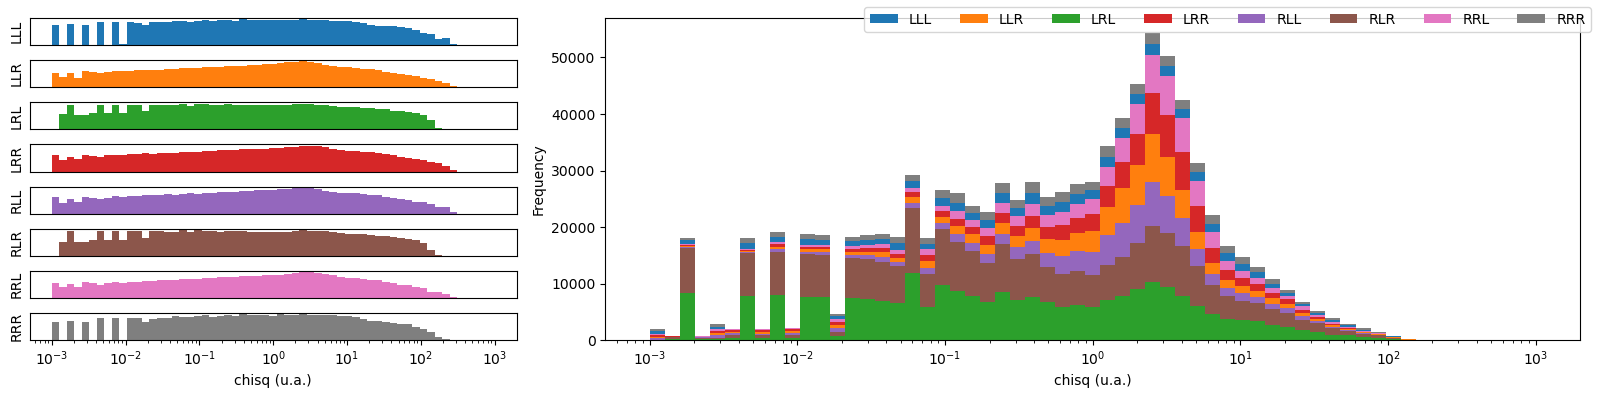

In [10]:
bins = np.logspace(-3, 3, 60)
# xrange = (-3, 3)
label = 'chisq (u.a.)'

def add_plot(ax):
    ax.set_xscale('log')
    pass


plot_split_pattID(src_df, 'chi2', bins = bins, label = label, add_plot = add_plot)

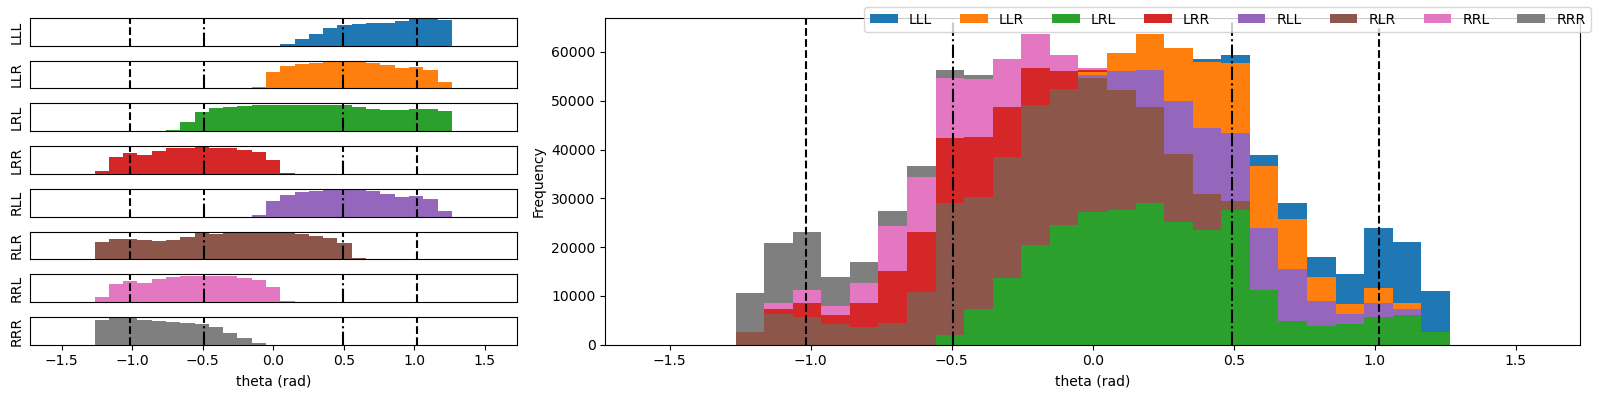

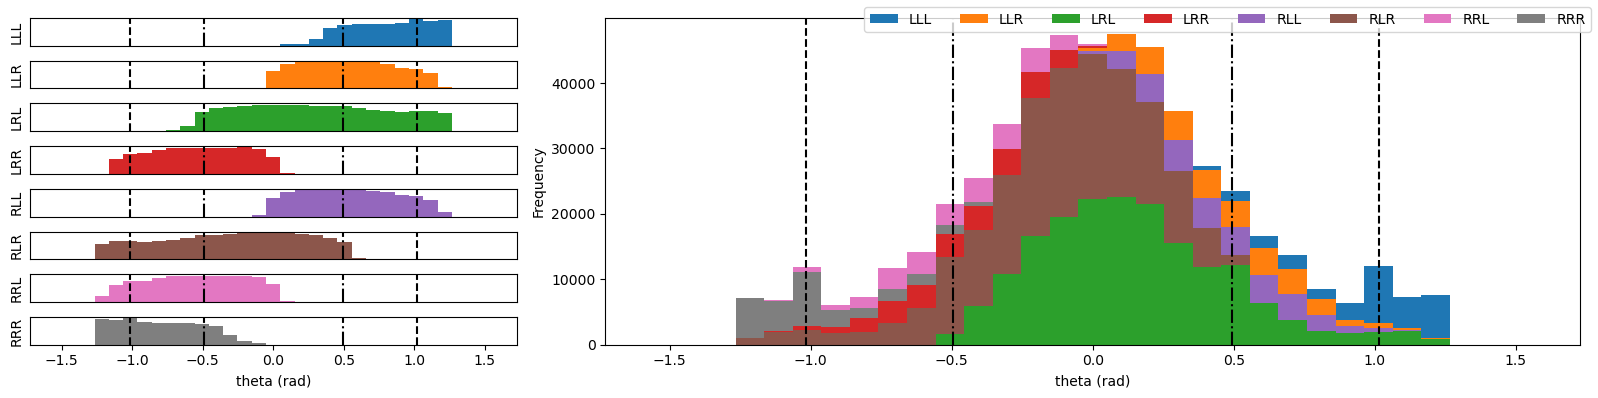

In [12]:
bins = 31
xrange = (-np.pi/2, np.pi/2)
label = 'theta (rad)'
def add_plot(ax):
    for s in [-1,1]:
        ax.axvline(np.arctan(s*(0.5*u.CELL_WIDTH)/(3*u.CELL_HEIGHT)), color='black', linestyle='-.')
        ax.axvline(np.arctan(s*(2*u.CELL_WIDTH)/(4*u.CELL_HEIGHT)), color='black', linestyle='--')



plot_split_pattID(src_df, 'theta', bins, xrange, label, add_plot)
plot_split_pattID(df, 'theta', bins, xrange, label, add_plot)

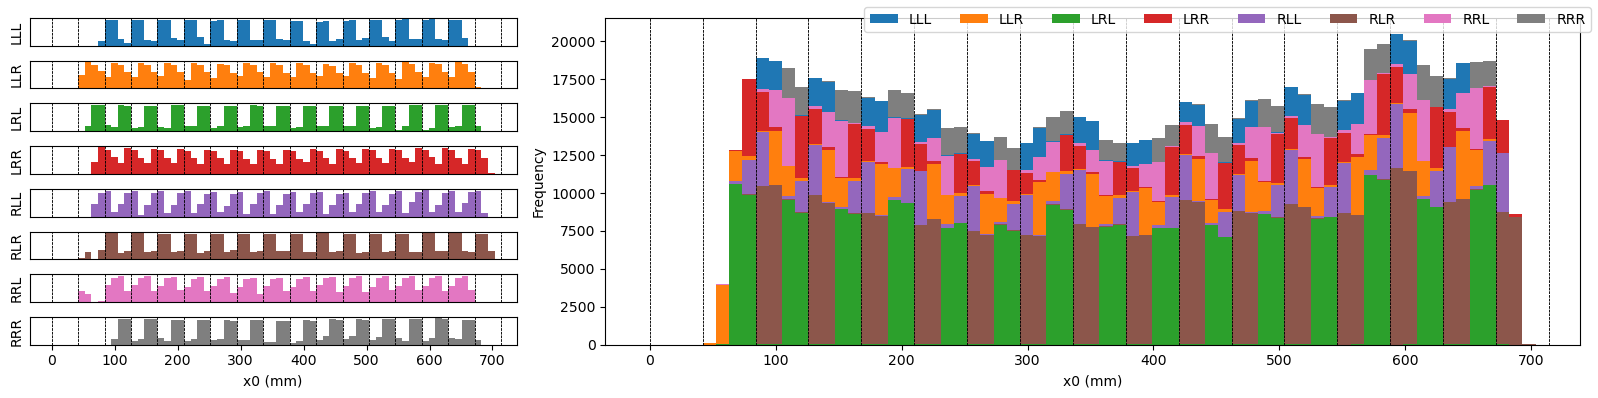

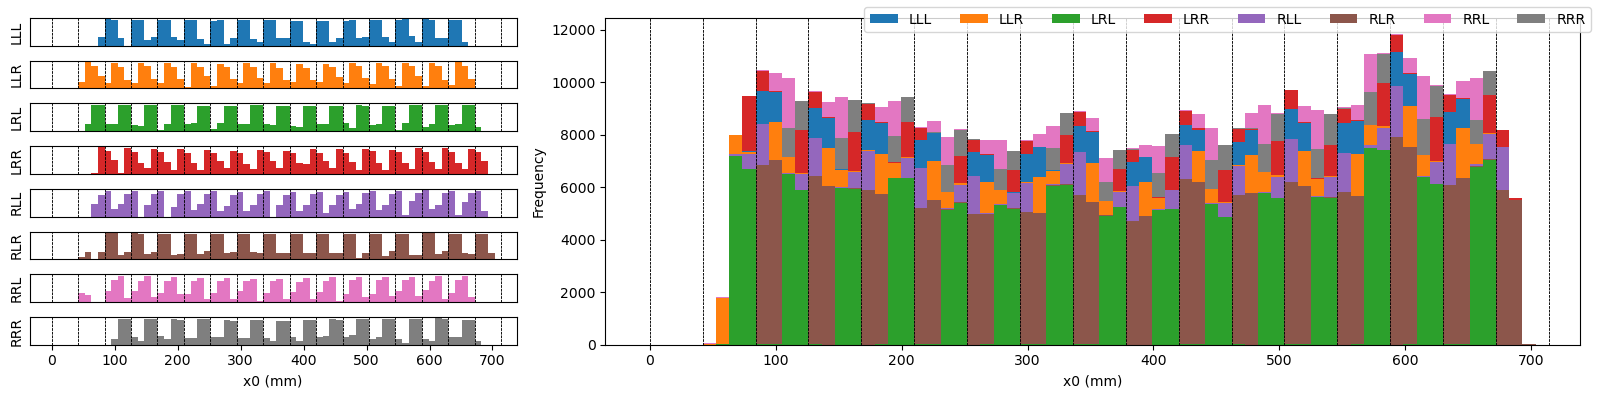

In [13]:
bins = np.arange(0,u.CELL_WIDTH*17,u.CELL_WIDTH/4)
xrange = (0, 17*u.CELL_WIDTH)
label = 'x0 (mm)'
def add_plot(ax):
    for s in [-1,1]:
        [ax.axvline(x, color='black', linestyle='--', lw=.5) for x in (np.arange(0,18))*u.CELL_WIDTH]

plot_split_pattID(src_df, 'x0', bins, xrange, label, add_plot)
plot_split_pattID(df, 'x0', bins, xrange, label, add_plot)

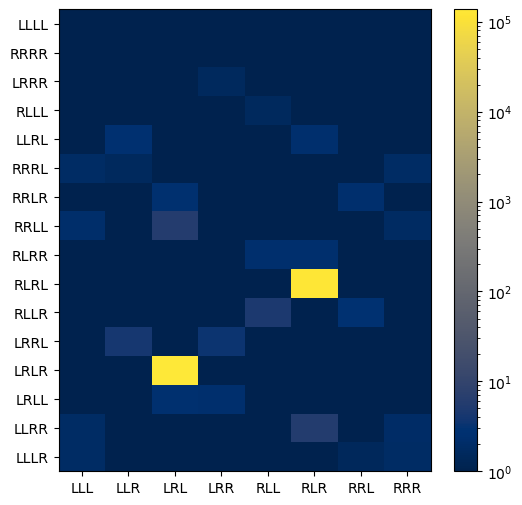

In [14]:
pattID_cat = df['pattID'].astype('category').cat
latsID_cat = df['latsID'].astype('category').cat
fig, ax = plt.subplots(1,1, figsize=(6,6))

# Crear el histograma 2D
hist2d = ax.hist2d(pattID_cat.codes.values, latsID_cat.codes.values,
           bins=[len(pattID_cat.categories), len(latsID_cat.categories)],
           range=((0, len(pattID_cat.categories)), (0, len(latsID_cat.categories))),
           cmap='cividis'
        )

norm = mpl.colors.LogNorm(vmin=1, vmax=hist2d[0].max())
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='cividis'), ax=ax)

# Ajustar las posiciones de los ticks para que estén en el centro de los bins
plt.xticks(np.arange(len(pattID_cat.categories))+0.5, pattID_cat.categories)
plt.yticks(np.arange(len(latsID_cat.categories))+0.5, latsID_cat.categories)

plt.show()


In [ ]:
df[(df.chi2<.1)].MT.dropna().median()

In [30]:
print(u.V_DRIFT, 0.5*u.CELL_WIDTH/df[(df.chi2<.1)].MT.dropna().median())

0.0545 0.05450000000000043


In [29]:
print(u.V_DRIFT, 0.5*u.CELL_WIDTH/df[(df.chi2<.1) & (df.MT<500) & (df.MT > 300)].MT.dropna().mean())

0.0545 0.0546053236890058


In [88]:
from dtupy_analysis.dqm.reco import SegDF

seg_df = SegDF.read_parquet('/nfs/cms/martialc/DTUpgrade/data/cosmic_240904_long.seg')

In [57]:
nmax = 30

with MuFile('/nfs/cms/martialc/DTUpgrade/data/cosmic_240904_long.parquet', batch_size=1e3) as file:
    range=((0,16),(1, 5))
    bins=(16, 4)
    hist = np.zeros(bins)
    for i, data in tqdm(enumerate(file)):
        # if i == nmax: break
        try:
            musgo = MuSGO(data, seg_df.get_segs(data))
            df = musgo.data.reset_index()
            hist += np.histogram2d(df.cell, df.layer, bins=bins, range=range)[0]
        except KeyboardInterrupt:
            break

0it [00:00, ?it/s]

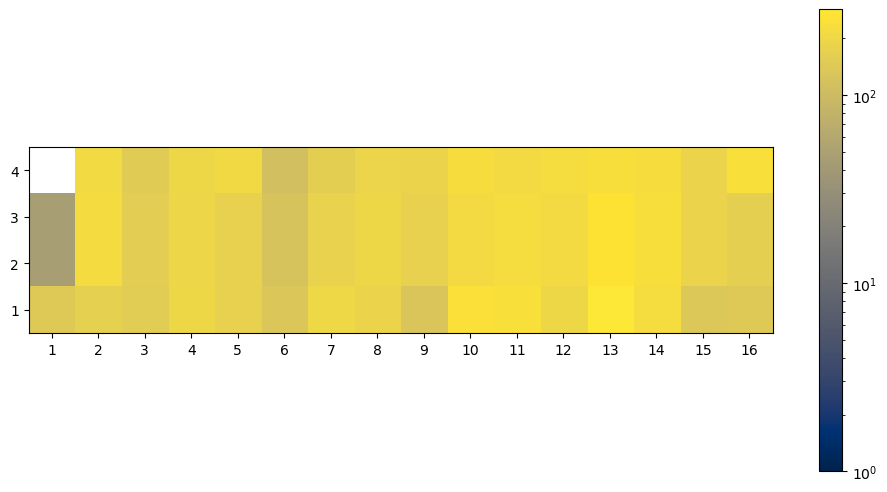

In [9]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
norm = mpl.colors.LogNorm(vmin=1, vmax=hist.max())
ax.imshow(hist[:,::-1].T, norm=norm, cmap='cividis')
ax.set_yticks(np.arange(4)[::-1], np.arange(1,5))
ax.set_xticks(np.arange(0,16), np.arange(1,17))
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='cividis'), ax = ax)
plt.show()

In [ ]:
range=((0,16),(1, 5))
bins=(16, 4)
hist = np.zeros(bins)
with MuFile('/nfs/cms/martialc/DTUpgrade/data/cosmic_240904_long.parquet', batch_size=1e3) as file:
    for i, data in tqdm(enumerate(file)):
        # if i == nmax: break
        try:
            musgo = MuSGO(data, seg_df.get_segs(data))
            df = musgo.data.reset_index()
            hist += np.histogram2d(df.cell, df.layer, bins=bins, range=range)[0]
        except KeyboardInterrupt:
            break

/tmp/ipykernel_23154/3481030025.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('cividis')


372.9820387687052


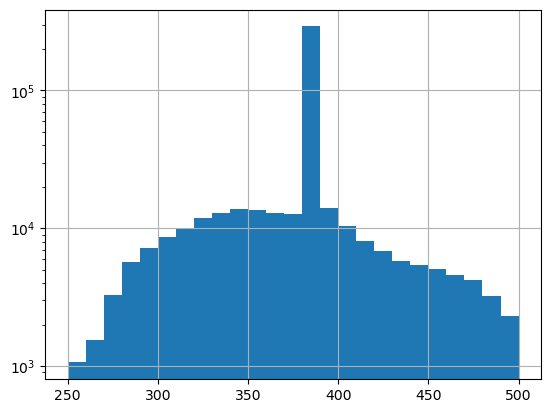

Text(0, 0.5, 'MT2 (ns)')

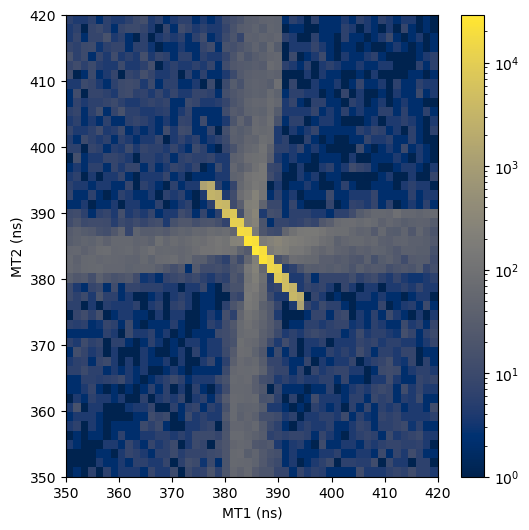

In [11]:
import matplotlib.cm as cm
chi2 = 1

norm = mpl.colors.LogNorm(vmin=1)
cmap = cm.get_cmap('cividis')
cmap.set_bad(cmap(1))

print(df[df.chi2<chi2].MT.dropna().mean())
df[df.chi2<chi2].MT.dropna().hist(bins=25, range= (250,500), log=True)
plt.show()

fig, ax = plt.subplots(1,1, figsize=(6,6))
h2=ax.hist2d(df[df.chi2<chi2].MT1, df[df.chi2<chi2].MT2, range =  2*[[350, 420]], bins = (50,50), norm=norm, cmap=cmap)
plt.colorbar(h2[3])
plt.xlim(350, 420)
plt.ylim(*plt.gca().get_xlim())

plt.xlabel('MT1 (ns)')
plt.ylabel('MT2 (ns)')



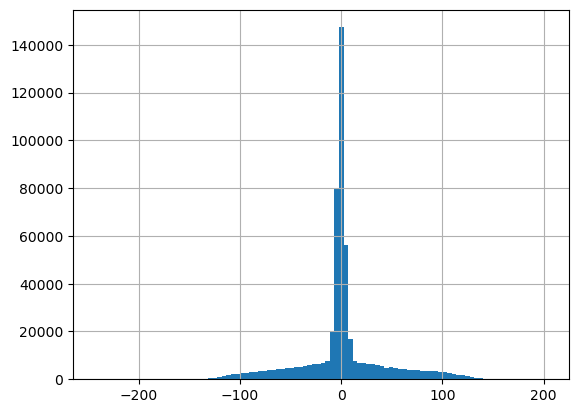

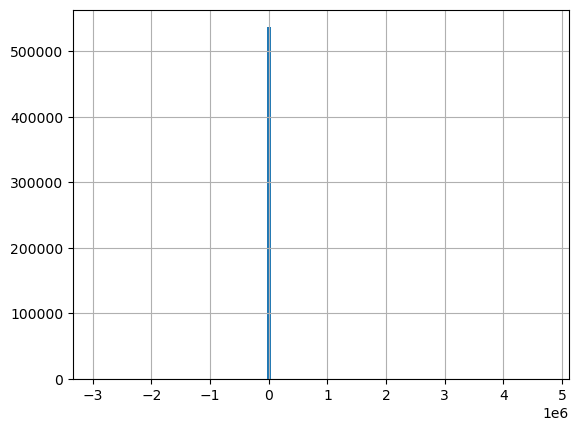

/tmp/ipykernel_23154/2638946253.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = get_cmap('cividis')


Text(0, 0.5, 'NT2 (ns)')

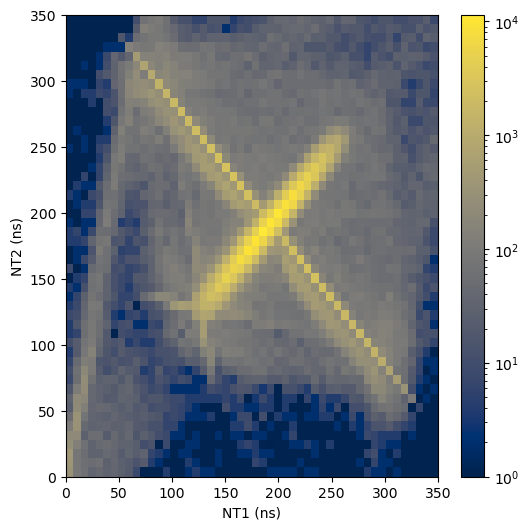

In [12]:
chi2 = 1

df[df.chi2<chi2].NT.dropna().hist(bins=100, log=False)
plt.show()

(0.5*(df[df.chi2<chi2].NT1 + df[df.chi2<chi2].NT2)).dropna().hist(bins=100, log=False)
plt.show()
hist_range = [0,350]

from matplotlib.cm import get_cmap
fig, ax = plt.subplots(1,1, figsize=(6,6))
norm = mpl.colors.LogNorm(vmin=1)
cm = get_cmap('cividis')
cm.set_bad(cm(1))

h2=ax.hist2d(df[df.chi2<chi2].NT1, df[df.chi2<chi2].NT2, range =  2*[hist_range,], bins = (50,50), norm=norm, cmap=cm)
plt.colorbar(h2[3])
plt.xlim(*hist_range)
plt.ylim(*hist_range)

plt.xlabel('NT1 (ns)')
plt.ylabel('NT2 (ns)')


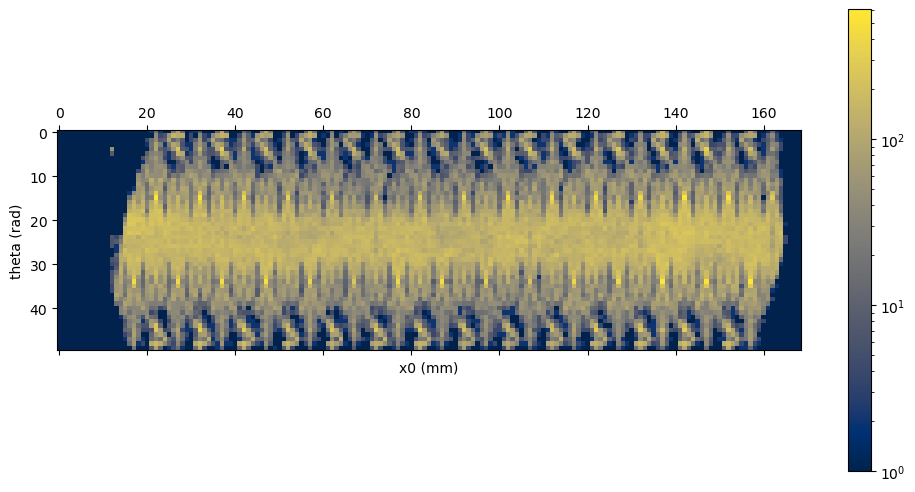

In [92]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
norm = mpl.colors.LogNorm(vmin=1)

hist2d = cts, bins, _ = np.histogram2d(df.x0, df.theta, bins = (np.arange(0,u.CELL_WIDTH*17,u.CELL_WIDTH/10),50))

_=ax.matshow(np.clip(cts.T, 1, np.inf), norm=norm, cmap='cividis')

# for s in [-1,1]:
#     ax.axhline(np.arctan(s*(0.5*u.CELL_WIDTH)/(3*u.CELL_HEIGHT)), color='white', linestyle='-.')
#     # ax.axhline(np.arctan(s*(2.5*u.CELL_WIDTH)/(4*u.CELL_HEIGHT)), color='white', linestyle='--')
#     ax.axhline(np.arctan(s*(2*u.CELL_WIDTH)/(4*u.CELL_HEIGHT)), color='white', linestyle='--')


ax.set_xlabel('x0 (mm)')
ax.set_ylabel('theta (rad)')
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='cividis'), ax = ax)
plt.show()
